# Numerical experiements for random scale-free graphs
This document reproduces the results of the paper for random scale-free bipartite graphs.

## 1. Imports

In [1]:
# Maths
import numpy as np
import math 
from math import pi 
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# Graph
import networkx as nx 
# Utilities
import copy
from tqdm.notebook import tqdm
import pandas as pd
import sys
import pickle
# Fit
from sklearn.linear_model import LinearRegression
# Parallelisation
from multiprocessing import Pool
# QWSearch
from qwgraph import QWSearch,coins,PipeLine,AddressingType,pipelines

# Plot configuration
sns.set()
sns.set_context("poster")
sns.set_style("ticks")

idc = lambda x : np.array(list(range(len(x))))

## 2. Functions to search nodes and generate graphs

In [2]:
def self_loop(G):
    nodes = copy.deepcopy(G.nodes())
    s = {}
    for i in nodes:
        G.add_edge(i,i)
        s[i] = (i,i)
    return s

def get_T_P(qw, ):
    G = nx.convert_node_labels_to_integers(nx.complete_graph(n))
    qw = QWSearch(G, starify=True) # Generation of the QW
    searched = [0]
    T,P = qw.get_T_P(pipelines.search_virtual_edges(coins.X, "grover", searched, -coins.X),waiting=30)
    dic = {"$N$":len(list(G.nodes())), "$M$":len(list(G.edges())), "$\\tilde N$":len(list(qw.nodes())), "$\\tilde M$":len(list(qw.edges())),
            "degree_centrality $G$":nx.degree_centrality(G)[0], "degree_centrality $\\tilde G$":nx.degree_centrality(qw.graph())[0], "$T$":T, "$P$":P,}
    return pd.DataFrame({i : [dic[i]] for i in dic})


def search_node(G):
    graph = copy.deepcopy(G)
    qw = QWSearch(G, starify=True) # Generation of the QW

    to_df = lambda dic,names : pd.DataFrame({names[0]:list(dic.keys()),names[1]:list(dic.values())})
    data = to_df(nx.degree_centrality(G),["node","degree"])
    
    l = []
    for u in tqdm(G.nodes()):
        T,P = qw.get_T_P(pipelines.search_virtual_edges(coins.X, "grover", [u], -coins.X),waiting=30)
        l.append([u,T,P])
    
    data = pd.merge(data,pd.DataFrame(l,columns=["node","T","P"]))
        
    nx.set_node_attributes(G, {i:j for i,j in zip(data.node,data.T)}, "T")
    nx.set_node_attributes(G, {i:j for i,j in zip(data.node,data.P)}, "P")
    
    data["number_edges"] = [len(list(G.edges()))]*len(data)
    data["number_nodes"] = [len(list(G.nodes()))]*len(data)
    data["diameter"] = [nx.diameter(G)]*len(data)
    data["density"] = [nx.density(G)]*len(data)
    
    return data     

In [3]:
def random_cluster(n,m,num_iter=10000,progress=False, rng=None):
    """
    This function create a random connected scale free bipartite graph with n0 nodes of color 0, n1 nodes of color 1 and m edges.
    """
    G=None 
    k = 0
    while G==None or not nx.is_connected(G):
        assert(k<=num_iter)
        #G = Graph.scale_free_bipartite(n0,n1,m,3,3,progress,rng=rng)
        #G = nx.bipartite.gnmk_random_graph(n0,n1,m)
        #G = nx.scale_free_graph(n0+n1).to_undirected()
        #G = nx.gnm_random_graph(n, m)
        G = nx.barabasi_albert_graph(n,m=int(np.round(m/n)))
        k+=1
    return G

## 3. Probability of success
We generate a graph randomly and try to fit the probability of success of every node in function of the degree centrality.

In [4]:
rng = np.random.default_rng(42)
G = random_cluster(1000, 10000, progress=True, rng=rng)
data0 = search_node(G)
data0

  0%|          | 0/1000 [00:00<?, ?it/s]

,node,degree,T,P,number_edges,number_nodes,diameter,density
0,0,0.156156,116,0.987025,9900,1000,4,0.01982
1,1,0.085085,116,0.976066,9900,1000,4,0.01982
2,2,0.067067,117,0.970006,9900,1000,4,0.01982
3,3,0.060060,117,0.966160,9900,1000,4,0.01982
4,4,0.064064,116,0.968107,9900,1000,4,0.01982
...,...,...,...,...,...,...,...,...
995,995,0.010010,129,0.827794,9900,1000,4,0.01982
996,996,0.010010,129,0.827599,9900,1000,4,0.01982
997,997,0.010010,125,0.827517,9900,1000,4,0.01982
998,998,0.010010,125,0.828752,9900,1000,4,0.01982


<AxesSubplot:xlabel='degree', ylabel='Count'>

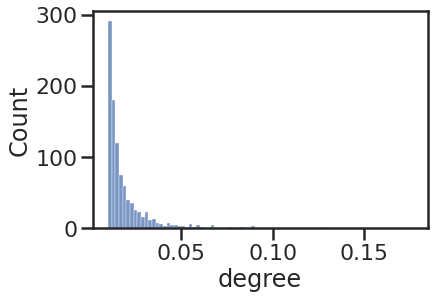

In [5]:
sns.histplot(data=data0,x="degree")

122.945

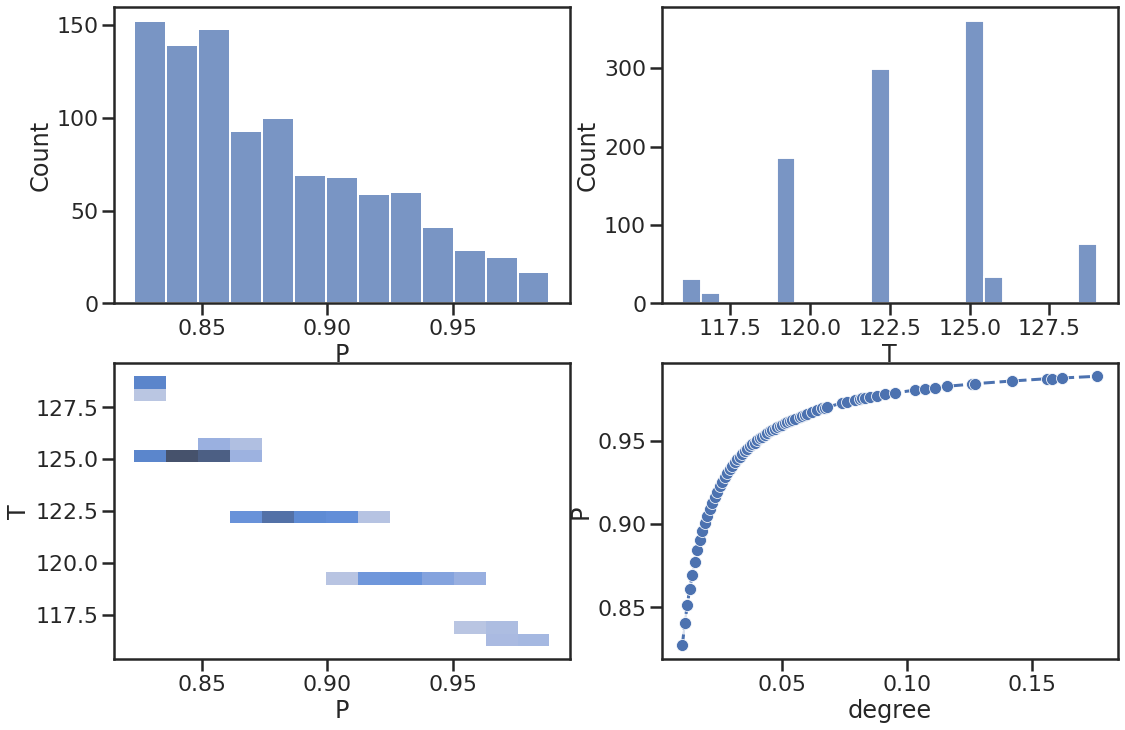

In [6]:
fig,ax = plt.subplots(2,2,figsize=(18,12))
sns.histplot(data=data0,x="P",ax=ax[0,0])
sns.histplot(data=data0,x="T",ax=ax[0,1])
sns.histplot(data=data0,x="P",y="T",ax=ax[1,0])
sns.lineplot(data=data0,x="degree",y="P",marker='o', linestyle='--',ax=ax[1,1])
np.mean(list(data0["T"]))

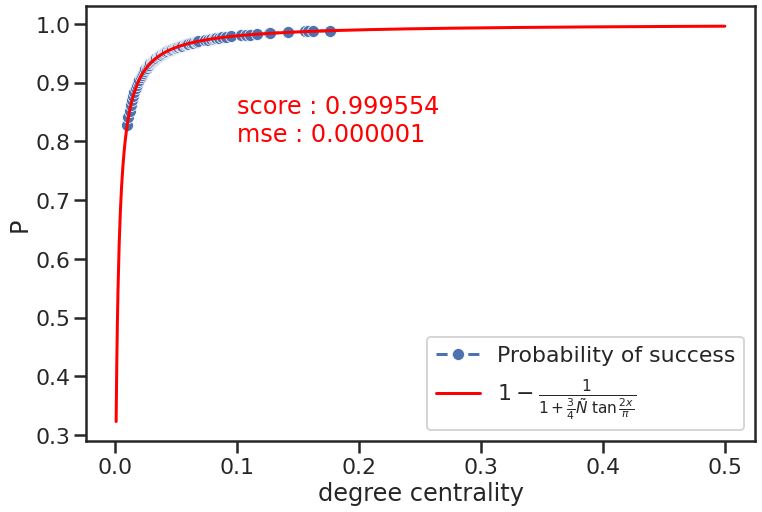

In [7]:
plt.figure(figsize=(12,8))
sns.lineplot(data=data0,x="degree",y=data0.P,marker='o', linestyle='--',label="Probability of success")
x = np.linspace(0.001,0.5,1000)
y = np.array(list(data0["P"]))
z = 1-1/(1+len(G)*0.75*np.tan(x*2/pi))
#z = 1/(1+1/(len(G)*0.34*x))
sns.lineplot(x=x,y=z, color="red", label="$1-\\frac{1}{1+\\frac{3}{4}\\tilde N \; \\tan \\frac{2x}{\\pi}}$")
x = np.array(list(data0["degree"]))
y = np.array(list(data0["P"]))
z = 1-1/(1+len(G)*0.75*np.tan(x*2/pi))
#z = 1/(1+1/(len(G)*0.34*x))
mse = np.mean((y-z)**2)
score = 1-np.mean((y-z)**2)/np.std(y)**2
plt.annotate("score : {:.6f}\nmse : {:.6f}".format(score,mse), xy=(0.1, 0.8),color="red")
plt.xlabel("degree centrality")
plt.savefig("img/scalefree_P.png", bbox_inches='tight')

score : 0.99947
intercept : 0.00000
coef : 750.74297



Text(0, 0.5, '$T^2$')

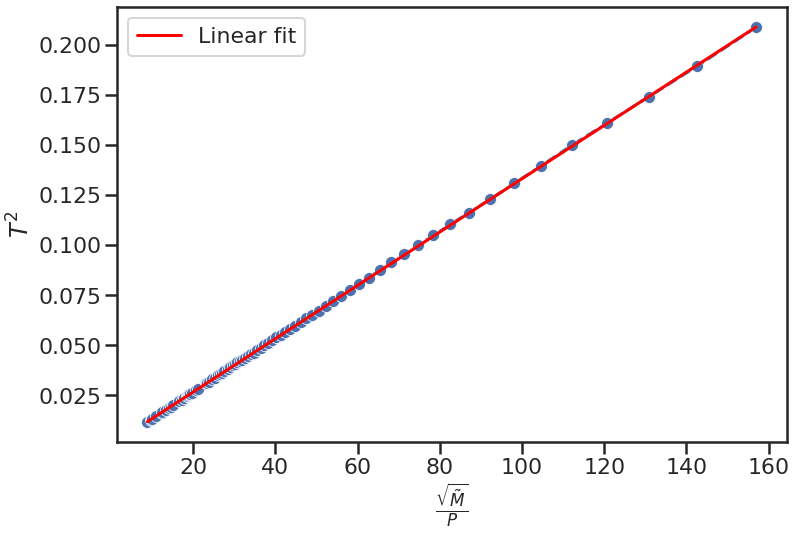

In [8]:
def lin_fit(x,y):
    X = np.array([[i] for i in x])
    reg = LinearRegression(fit_intercept=False).fit(X, y)
    text = "score : {:.5f}\nintercept : {:.5f}\ncoef : {:.5f}\n".format(reg.score(X,y),reg.intercept_,1/reg.coef_[0])
    print(text)
    return reg.predict(X), text

x = np.array(list(data0["degree"]))
y = np.array(list(data0["P"]))
x = 1/np.tan(x*2/pi)
y = 1/y-1
z, text = lin_fit(x,y)

plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='o', linestyle='--')
sns.lineplot(x=x,y=z, color="red", label="Linear fit")
plt.annotate(text, xy=(25000, 15000),color="red")
plt.xlabel("$\\frac{\\sqrt{\\tilde M}}{P}$")
plt.ylabel("$T^2$")

## 4. Hitting time
We generate a graph randomly and try to fit the hitting time of every node in function of the probability of success.

In [9]:
rng = np.random.default_rng(42)
G = random_cluster(1000, 10000, progress=True, rng=rng)
data0 = search_node(G)
data0

  0%|          | 0/1000 [00:00<?, ?it/s]

,node,degree,T,P,number_edges,number_nodes,diameter,density
0,0,0.113113,116,0.982080,9900,1000,4,0.01982
1,1,0.050050,119,0.959675,9900,1000,4,0.01982
2,2,0.080080,116,0.974609,9900,1000,4,0.01982
3,3,0.133133,116,0.984753,9900,1000,4,0.01982
4,4,0.043043,119,0.953377,9900,1000,4,0.01982
...,...,...,...,...,...,...,...,...
995,995,0.010010,129,0.825385,9900,1000,4,0.01982
996,996,0.010010,129,0.826557,9900,1000,4,0.01982
997,997,0.010010,125,0.827273,9900,1000,4,0.01982
998,998,0.010010,125,0.828301,9900,1000,4,0.01982


122.987

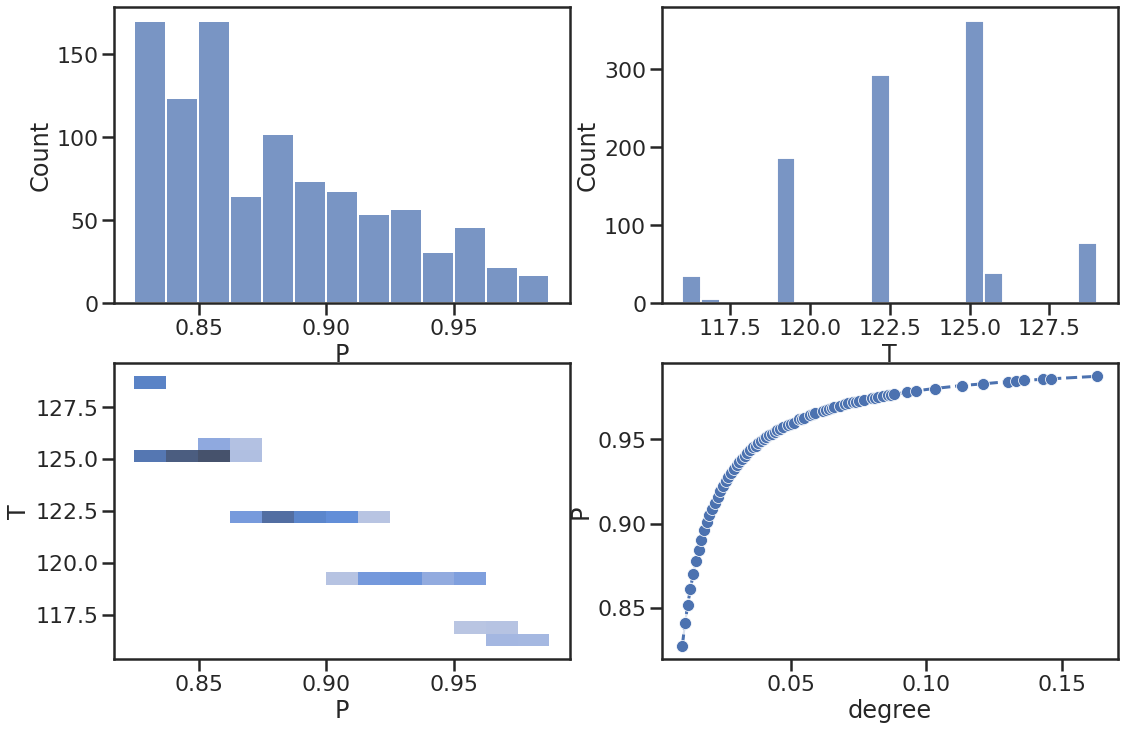

In [10]:
fig,ax = plt.subplots(2,2,figsize=(18,12))
sns.histplot(data=data0,x="P",ax=ax[0,0])
sns.histplot(data=data0,x="T",ax=ax[0,1])
sns.histplot(data=data0,x="P",y="T",ax=ax[1,0])
sns.lineplot(data=data0,x="degree",y="P",marker='o', linestyle='--',ax=ax[1,1])
np.mean(list(data0["T"]))

score : 0.86347
intercept : -64.30228
coef : 1.22173



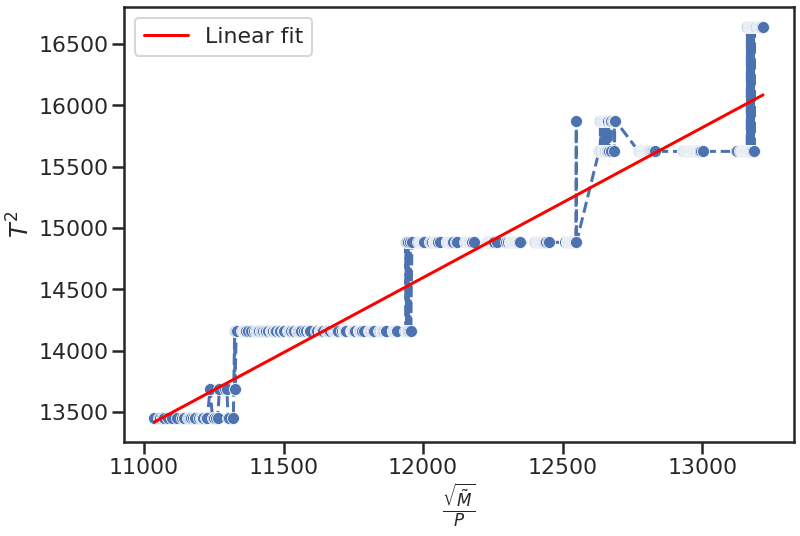

In [11]:
def lin_fit(x,y):
    X = np.array([[i] for i in x])
    reg = LinearRegression(fit_intercept=True).fit(X, y)
    text = "score : {:.5f}\nintercept : {:.5f}\ncoef : {:.5f}\n".format(reg.score(X,y),reg.intercept_,reg.coef_[0])
    print(text)
    return reg.predict(X), text

x = np.array(list(data0["P"]))
y = np.array(list(data0["T"]))
x = (len(G) + len(list(G.edges())))/x
y = y**2
z, text = lin_fit(x,y)

plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='o', linestyle='--')
sns.lineplot(x=x,y=z, color="red", label="Linear fit")
plt.annotate(text, xy=(25000, 15000),color="red")
plt.xlabel("$\\frac{\\sqrt{\\tilde M}}{P}$")
plt.ylabel("$T^2$")
plt.savefig("img/scalefree_T.png", bbox_inches='tight')

## 5. Generating a **lot** of random graphs and checking the model

In [12]:
def compute_xp_foo(args):
    G,i = args
    tmp = search_node(G)
    tmp["xp"] = i
    return tmp

def compute_xp(graphs):
    data = pd.DataFrame()
    args = [(graphs[i],i) for i in range(len(graphs))]
    with Pool(15) as p:
        data = pd.concat(list(tqdm(p.imap_unordered(compute_xp_foo,args),total=len(args),desc="Searching all nodes")))
    return data

In [15]:
rng = np.random.default_rng(42)
def foo(k):
    global rng
    n = np.random.randint(100,200)
    m = np.random.randint(5*(n),0.5*n**2)
    return random_cluster(n, int(m), rng=rng)

if False: # Change this boolean to False if you don't want to compute everything again
    args = list(range(1000))
    graphs = list(tqdm(map(foo,args),total=len(args),desc="Graph Generation"))
    data = compute_xp(graphs)
    data = data.reset_index()
    def foo(xp):
        return (xp["number_edges"]+xp["number_nodes"])/xp["T"]**2

    l = []
    for i in tqdm(range(len(data))):
        l.append(foo(data.loc[i]))

    data["ratio"] = l
    pickle.dump(data,open("data.pkl","wb"))
else:
    data = pickle.load(open("data.pkl","rb"))
data

,index,node,degree,T,P,number_edges,number_nodes,diameter,density,xp,ratio
0,0,0,0.414815,41,0.964764,1260,136,3,0.137255,9,0.830458
1,1,1,0.266667,43,0.945422,1260,136,3,0.137255,9,0.755003
2,2,2,0.066667,47,0.814107,1260,136,3,0.137255,9,0.631960
3,3,3,0.140741,44,0.902574,1260,136,3,0.137255,9,0.721074
4,4,4,0.133333,43,0.898637,1260,136,3,0.137255,9,0.755003
...,...,...,...,...,...,...,...,...,...,...,...
148188,185,185,0.343915,103,0.970047,8064,190,2,0.449123,994,0.778019
148189,186,186,0.343915,103,0.970031,8064,190,2,0.449123,994,0.778019
148190,187,187,0.349206,103,0.970387,8064,190,2,0.449123,994,0.778019
148191,188,188,0.338624,103,0.969628,8064,190,2,0.449123,994,0.778019


In [16]:
P = np.array(1-1/(1+0.75*data["number_nodes"]*np.tan(2*data["degree"]/pi))) # Formula for P
T = np.array(np.sqrt(1.22 * (data["number_edges"] + data["number_nodes"])/P)) # Formula for T
p = np.array(list(data["P"])) # numerical values for P
t = np.array(list(data["T"])) # numerical values for T


print("mse T : ", np.mean((T-t)**2))
print("mse P : ", np.mean((P-p)**2))

print("score T : ", 1-np.mean((T-t)**2)/np.std(t)**2)
print("score P : ", 1-np.mean((P-p)**2)/np.std(p)**2)

mse T :  0.5237187281594099
mse P :  2.5618806822927392e-06
score T :  0.9985740735579267
score P :  0.9986901398080446
